# СБОРНЫЙ ПРОЕКТ 2. HR - АНАЛИТИКА

Цель помочь: оптимизиация управлением персонала, для реализации которой необходимо выполнить две задачи:

-  построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Задачи также разбиты на подзадачи, описание которых представлено в начале решения каждой задачи.


Для первой задачи данные:
- тренировочной выборки: train_job_satisfaction_rate.csv
- входных ризнаков тестовой выборки: test_features.csv
- целевого признака тестовой выборки: test_target_job_satisfaction_rate.csv

Для этой задачи заказчик предоставил данные с признаками:

- id — уникальный идентификатор + сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

Для второй задачи данные:
- тренировочной выборки: train_quit.csv
- входных ризнаков тестовой выборки: test_features.csv
- целевого признака тестовой выборки: test_target_quit.csv

Для этой задачи заказчик предоставил данные с признаками:

- id — уникальный идентификатор + сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компа нии, целевой признак.
- quit — увольнение сотрудника из компании, целевой признак.

In [1]:
! pip  install  phik  -q
!pip install shap -q
!pip install imbalanced-learn -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import warnings

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.dummy import DummyClassifier

In [4]:
from sklearn.metrics import make_scorer

In [5]:
from phik import phik_matrix

In [6]:
#Константы
RANDOM_STATE = 42

# ЗАДАЧА 1. Предсказание уровня удовлетворённости сотрудника

Задачи:
-  Загрузить данные из файлов rain_job_satisfaction_rate.csv, test_features.csv, test_target_job_satisfaction_rate.csv, подготовить данные для последующего анализа.
- При необходимости выполнить предобработку. При наличии пропущенных значений заполнить их в пайплайне.
- Исследовать все признаки и сделать выводы о том, как их нужно подготовить.
- Подготовку признаков выполнить в пайплайне, дополнив пайплайн шага предобработки. При кодировании учесть особенности признаков и моделей используя как минимум два кодировщика.
- Обучить как минимум две модели: линейную и дерево решений. Подобрать гиперпараметры как минимум для моделей.
- Выбрать лучшую модель и проверить её качество на основе новой метрики — SMAPE («симметричное среднее абсолютное процентное отклонение»). Написать функцию, которая принимает на вход массивы NumPy или объекты Series в pandas и возвращает значение метрики SMAPE.
- Сделать промежуточные выводы о том, какая модель справилась лучше, аргументировать выводы.

#  ЗАГРУЗКА ДАННЫХ
На начальном этапе работы с данными необходимо провести загруску данных из предоставленных файлов и посмотреть общую информацию по данным файлам. После просмотра сделать соответствующие выводы, касаемо преобработки данных.

In [7]:
train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')

In [8]:
display(train.head(5))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [9]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None


In [10]:
test = pd.read_csv('/datasets/test_features.csv')

In [11]:
display(test.head(5))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [12]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


In [13]:
target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [14]:
display(target.head(5))

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [15]:
print(target.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


# Вывод
После загрузки данных и первичного просмотра файла было установлено, что:
1. во всех данных корректно было введено название колон
2. всем данным корректно присвоен тип данных.

В предобработке данные неоходимо проверить на пропуски и дубликаты.

# ПРЕДОБРАБОТКА ДАННЫХ
На данном этапе необходимо все данные проверить на наличие дубликатов и пропусков и по возможности сделать замену, если это возможно, удалить(если это не сильно скажется на данных) или оставить без именений.

## работа с данными train

In [16]:
#print(train.info())

In [17]:
print(train.isna().sum())

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


In [18]:
display(train[train['dept'].isna()])

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [19]:
display(train[train['level'].isna()])

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


In [20]:
print('количество строк в данных: ',train.shape[0])
print('количество дубликатов в данных: ',train.duplicated().sum())

количество строк в данных:  4000
количество дубликатов в данных:  0


In [21]:
print ('Процент пропусков в столбце "dept"',round(train['dept'].isna().sum() / train.shape[0]* 100,1))
print ('Процент пропусков в столбце "level"',round(train['level'].isna().sum() / train.shape[0]* 100,1))

Процент пропусков в столбце "dept" 0.2
Процент пропусков в столбце "level" 0.1


In [22]:
print ('уникальные значения столбца dept :',train['dept'].unique())
print ('уникальные значения столбца level :',train['level'].unique())
print ('уникальные значения столбца workload :',train['workload'].unique())
print ('уникальные значения столбца last_year_promo :',train['last_year_promo'].unique())
print ('уникальные значения столбца last_year_violations :',train['last_year_violations'].unique())
print ('уникальные значения столбца supervisor_evaluation :',train['supervisor_evaluation'].unique())

уникальные значения столбца dept : ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
уникальные значения столбца level : ['junior' 'middle' 'sinior' nan]
уникальные значения столбца workload : ['medium' 'high' 'low']
уникальные значения столбца last_year_promo : ['no' 'yes']
уникальные значения столбца last_year_violations : ['no' 'yes']
уникальные значения столбца supervisor_evaluation : [1 5 2 3 4]


In [23]:
train = train.sort_values(by = 'id')
train = train.set_index('id')
display(train.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100954,purchasing,junior,low,1,no,no,4,15600,0.60
101057,sales,junior,low,1,no,yes,4,19200,0.45
101074,sales,junior,medium,2,no,no,2,20400,0.36
101081,sales,middle,low,2,no,no,4,28800,0.66
101129,technology,junior,medium,1,no,no,4,34800,0.71


## Вывод
После преобоработки данного файла было сделано:
1. было определено 6 строк с пропусками в колонне 'dept', поскольку это составляет 0.2% от всех данных.
2. было определено 4 строки с пропусками в колонне 'level', поскольку это составляет 0.1% от всех данных.
3. в данных был убран столбец с id, он стал порядком строки. Также данные были отсортированы по возростанию id.
4. поиск дубликатов без id = 245, что составляет 6.1% от всех данных. Было принято решение их удалить.
5. проверка на уникальность данных выявела дефекты из-за пунков 1 и 2.

Количество строк: 4000

Новое количество строк: 3755

## работа с данными test

In [24]:
test = test.sort_values(by = 'id')

In [25]:
print(test.isna().sum())

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


In [26]:
print('количество строк в данных: ',test.shape[0])
print('количество дубликатов в данных: ',test.duplicated().sum())

количество строк в данных:  2000
количество дубликатов в данных:  0


In [27]:
print ('Процент пропусков в столбце "dept"',round(test['dept'].isna().sum() / test.shape[0]* 100,1))
print ('Процент пропусков в столбце "level"',round(test['level'].isna().sum() / test.shape[0]* 100,1))

Процент пропусков в столбце "dept" 0.1
Процент пропусков в столбце "level" 0.0


In [28]:
test = test.set_index('id')
display(test.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


In [29]:
print('количество дубликатов без id: ',test.duplicated().sum())
print('процентное соотношение :',round(test.duplicated().sum() / test.shape[0]* 100,1))

количество дубликатов без id:  557
процентное соотношение : 27.8


In [30]:
print ('уникальные значения столбца dept :',test['dept'].unique())
print ('уникальные значения столбца level :',test['level'].unique())
print ('уникальные значения столбца workload :',test['workload'].unique())
print ('уникальные значения столбца last_year_promo :',test['last_year_promo'].unique())
print ('уникальные значения столбца last_year_violations :',test['last_year_violations'].unique())

уникальные значения столбца dept : ['hr' 'marketing' 'purchasing' 'sales' 'technology' nan ' ']
уникальные значения столбца level : ['junior' 'middle' 'sinior' nan]
уникальные значения столбца workload : ['low' 'high' 'medium' ' ']
уникальные значения столбца last_year_promo : ['no' 'yes']
уникальные значения столбца last_year_violations : ['no' 'yes']


In [31]:
display(test.query('dept == " "').head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
822186,,middle,medium,3,no,no,4,38400


In [32]:
display(test.query('workload == " "').head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
590867,marketing,junior,,4,no,no,4,28800


In [33]:
#test = test.replace(' ', np.nan)

In [34]:
#test['level'] = test['level'].str.replace('sinior', 'senior')

In [35]:
#print ('уникальные значения столбца dept :',test['dept'].unique())
#print ('уникальные значения столбца level :',test['level'].unique())
#print ('уникальные значения столбца workload :',test['workload'].unique())
#print ('уникальные значения столбца last_year_promo :',test['last_year_promo'].unique())
#print ('уникальные значения столбца last_year_violations :',test['last_year_violations'].unique())

## Вывод
После преобоработки данного файла было сделано:
1. было обнаружено 2 строки с пропусками в колонне 'dept', поскольку это составляет 0.1% от всех данных.
2. была обнаружена 1 строка с пропусками в колонне 'level', поскольку это составляет 0.0% от всех данных.
3. поиск дубликатов с id - было невыявлено, без id = 557, что составляет 27.9% от всех данных. 
4. Проверка на уникальность данных выявлела заполнение ' ' в категориальных признаках dept и workload. Также была обнаружена неправильная записать 'sinior' в колоне 'level'. Данные дефекты будут исправлены в пайплайне.
5. Данные были отсортированы по возрастанию значений id.


Было принято решение не удалалять пропуски, а сделать обработку в пайплайне.

Количество строк: 2000

## работа с данными target

In [36]:
print(target.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


In [37]:
target = target.sort_values(by = 'id')

In [38]:
target = target.set_index('id')
display(target.head())

,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69


In [39]:
print(target.isna().sum())

job_satisfaction_rate    0
dtype: int64


In [40]:
print('количество строк в данных: ',target.shape[0])

количество строк в данных:  2000


## Вывод 
Предобработка данных не потребовалась.

Данные были отсортированы по возрастанию значений id

Количество строк: 2000

# Вывод

В предобработке данных каждый файл просматривался на наличие пропусков и дубликатов.

В данных train было сделано:
1. было определено 6 строк с пропусками в колонне 'dept', поскольку это составляет 0.2% от всех данных.
2. было определено 4 строки с пропусками в колонне 'level', поскольку это составляет 0.1% от всех данных.
3. В данных был убран столбец с id, он стал порядком строки. Также данные были отсортированы по возростанию id.
4. поиск дубликатов без id = 245, что составляет 6.1% от всех данных. Было принято решение их удалить, но когда будет работа по обучению модели.
5. Проверка на уникальность данных выявела дефекты из-за пунков 1 и 2.

Количество строк: 4000

В данных test было сделано:
1. было обнаружено 2 строки с пропусками в колонне 'dept', поскольку это составляет 0.1% от всех данных.
2. была обнаружена 1 строка с пропусками в колонне 'level', поскольку это составляет 0.0% от всех данных.
3. поиск дубликатов с id - было невыявлено, без id = 557, что составляет 27.9% от всех данных. 
4. Проверка на уникальность данных выявлела заполнение ' ' в категориальных признаках dept и workload. Также была обнаружена неправильная записать 'sinior' в колоне 'level'. Все эти дефекты будут изменены в пайплайне
5. Данные были отсортированы по возрастанию значений id.

Было принято решение не удалалять пропуски, а сделать обработку в пайплайне.

Количество строк: 2000

Предобработка данных в target не потребовалась.Данные были отсортированы по возрастанию значений id.

Количество строк: 2000


# ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ
На данном этапе необходимо провести исследовательский анализ данных всех признаков и на полученных результатах сделать вывод о способах подготовки данных. Также провести корреляйионный анализ данных.

In [41]:
train_1 = train.reset_index()

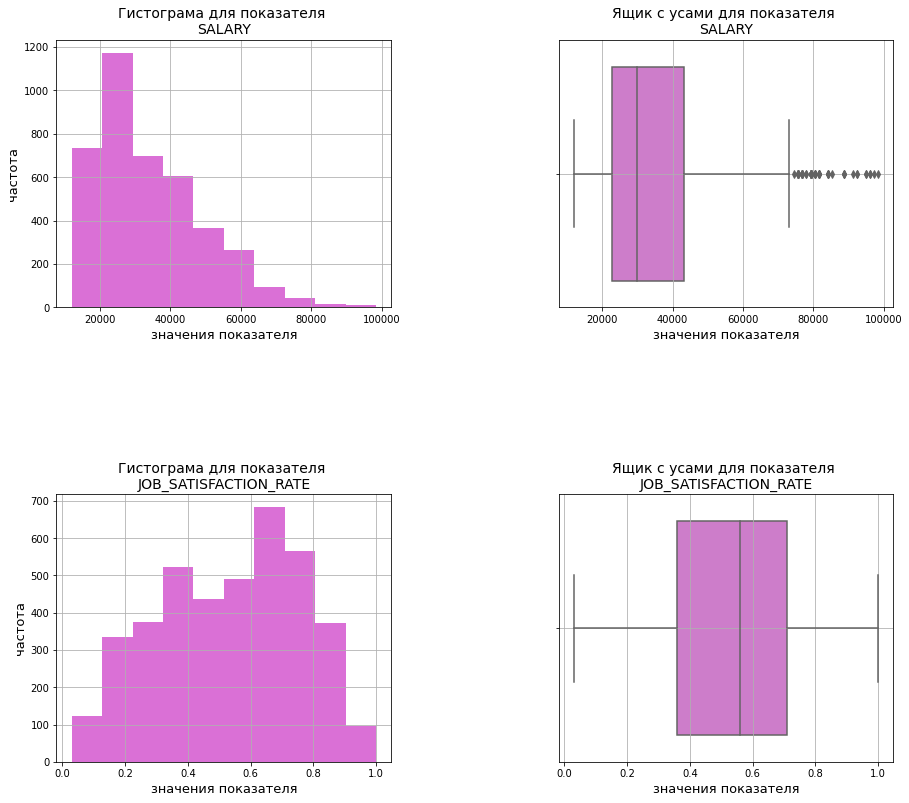

In [42]:
position = 0
plt.figure(figsize=[15,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'salary',
    'job_satisfaction_rate' 
]

for name in list:
    position += 1
    
    df1 = train_1[name]
    plt.subplot(4, 2, position)
    df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Гистограма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = train_1[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

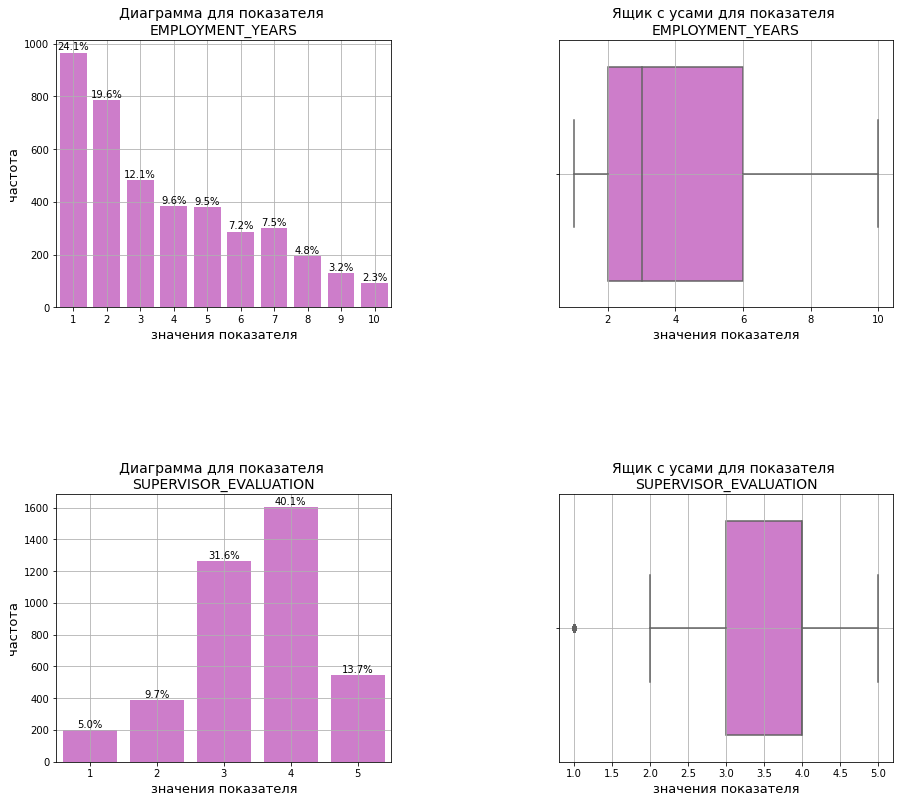

In [43]:
position = 0
plt.figure(figsize=[15,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'employment_years', 
    'supervisor_evaluation'
]

for name in list:
    position += 1
    
    df1 = train_1[name]
    plt.subplot(4, 2, position)
    ax = sns.countplot(x = name, data =train, color = 'orchid')
    #df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Диаграмма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    for p in ax.patches:
        # print(p.get_facecolor(), p.get_label())
        percentage = f'{100 * p.get_height() / len(df1):.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    
    position += 1
    df2 = train_1[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

In [44]:
display(train_1.query('supervisor_evaluation == 1'))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
33,107782,purchasing,junior,low,2,no,yes,1,18000,0.33
37,108560,sales,sinior,high,2,no,no,1,68400,0.16
78,121506,purchasing,middle,high,4,no,no,1,51600,0.21
105,126257,purchasing,junior,medium,1,no,no,1,27600,0.39
122,130717,technology,middle,medium,5,no,yes,1,49200,0.34
...,...,...,...,...,...,...,...,...,...,...
3932,981769,marketing,junior,medium,2,no,no,1,22800,0.32
3970,990103,purchasing,middle,medium,2,no,no,1,42000,0.33
3985,994358,purchasing,middle,medium,4,yes,no,1,42000,0.50
3988,995866,marketing,middle,low,6,no,no,1,30000,0.53


In [45]:
list = [ 
    'employment_years', 
    'supervisor_evaluation',
    'salary',
    'job_satisfaction_rate' 
]

for name in list:
    df1 = train_1[name]
    print(f'Характеристики количественного показателя {name.upper()}')
    print(df1.describe(),'\n')

Характеристики количественного показателя EMPLOYMENT_YEARS
count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64 

Характеристики количественного показателя SUPERVISOR_EVALUATION
count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64 

Характеристики количественного показателя SALARY
count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64 

Характеристики количественного показателя JOB_SATISFACTION_RATE
count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%     

<Figure size 1440x5400 with 0 Axes>

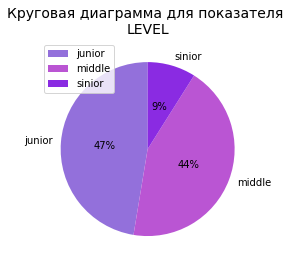

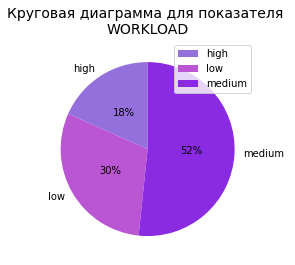

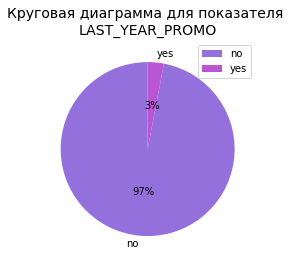

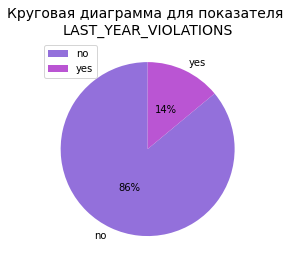

In [46]:
position = 0
plt.figure(figsize=[20,75]);
plt.subplots_adjust(wspace=0.5, hspace=1.0);

list = ['level','workload',  'last_year_promo', 'last_year_violations']


for name in list:
    position += 1
    df1 = train_1.pivot_table(index = name, values = 'id', aggfunc = 'count')
    df1.plot(
        kind = 'pie',
        subplots=True,
        autopct='%.0f%%',
        colors=['mediumpurple', 'mediumorchid', 'blueviolet'],
        startangle=90, 
        pctdistance=0.5
    );
    plt.title(f'Круговая диаграмма для показателя \n{name.upper()}', fontsize=14);
    plt.ylabel("");
    plt.show();

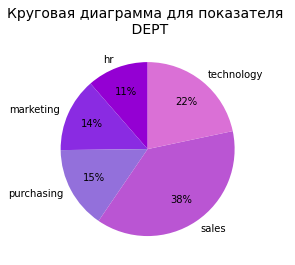

In [47]:
df1 = train_1.pivot_table(index = 'dept', values = 'id', aggfunc = 'count')
df1.plot(
    kind = 'pie'
    ,subplots=True
    ,autopct='%.0f%%'
    ,colors=[ 'darkviolet', 'blueviolet', 'mediumpurple', 'mediumorchid', 'orchid', 'violet']
    ,startangle=90
    ,pctdistance=0.7);
plt.title(f'Круговая диаграмма для показателя \n DEPT', fontsize=14);
plt.ylabel("");
plt.legend().remove();
plt.show();

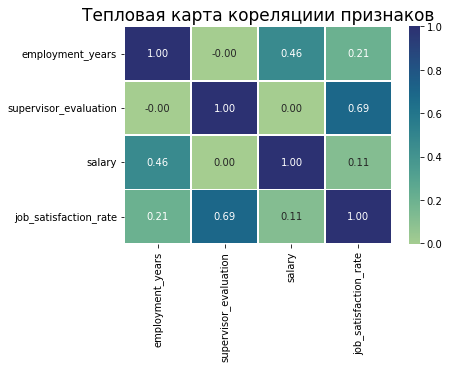

In [48]:
plt.figure(figsize=(6, 4));
sns.heatmap(
    train.corr()
    ,annot = True
    ,fmt = '.2f'
    ,linewidth=.5
    ,cmap="crest"
);
plt.title('Тепловая карта кореляциии признаков', fontsize=17);

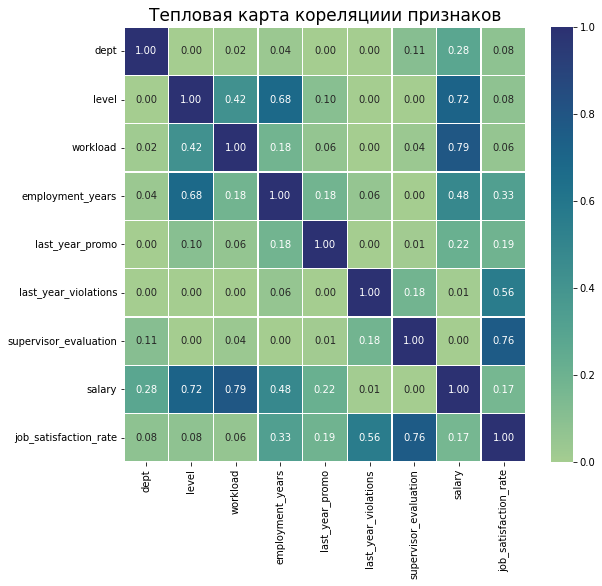

In [49]:
plt.figure(figsize=(9, 8));
sns.heatmap(
    train.phik_matrix(interval_cols=['salary','job_satisfaction_rate'])
    ,annot = True
    ,fmt = '.2f'
    ,linewidth=.5
    ,cmap="crest"
);
plt.title('Тепловая карта кореляциии признаков', fontsize=17);

Аналогичный анализ (EDA и корреляциия) нужно провести для test выборки, поскольку разделением данных не было, необходимо убедиться,что в данных нет существенных различий в части распределений признаков и что оценка модели, полученная на test выборке, будет корректной.

In [50]:
test_1 = test.reset_index()

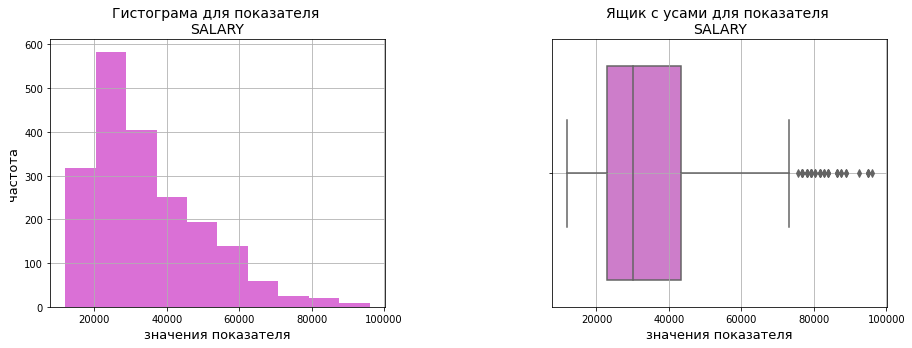

In [51]:
position = 0
plt.figure(figsize=[15,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'salary' 
]

for name in list:
    position += 1
    
    df1 = test_1[name]
    plt.subplot(4, 2, position)
    df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Гистограма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = test_1[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

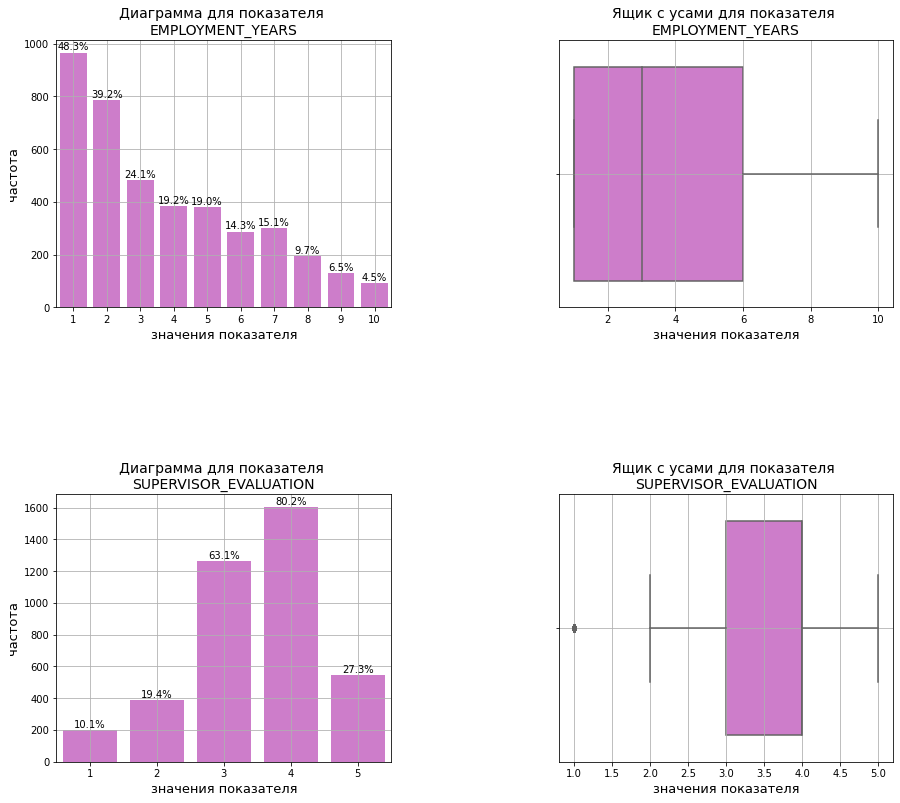

In [52]:
position = 0
plt.figure(figsize=[15,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'employment_years', 
    'supervisor_evaluation'
]

for name in list:
    position += 1
    
    df1 = test_1[name]
    plt.subplot(4, 2, position)
    ax = sns.countplot(x = name, data =train, color = 'orchid')
    #df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Диаграмма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    for p in ax.patches:
        # print(p.get_facecolor(), p.get_label())
        percentage = f'{100 * p.get_height() / len(df1):.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    
    position += 1
    df2 = test_1[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

In [53]:
list = [ 
    'employment_years', 
    'supervisor_evaluation',
    'salary'
]

for name in list:
    df1 = test_1[name]
    print(f'Характеристики количественного показателя {name.upper()}')
    print(df1.describe(),'\n')

Характеристики количественного показателя EMPLOYMENT_YEARS
count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64 

Характеристики количественного показателя SUPERVISOR_EVALUATION
count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64 

Характеристики количественного показателя SALARY
count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64 



<Figure size 1440x5400 with 0 Axes>

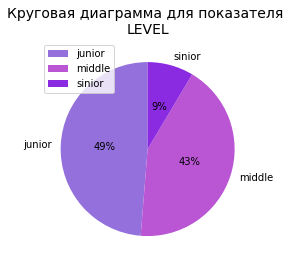

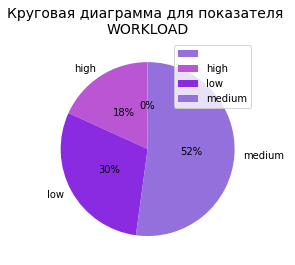

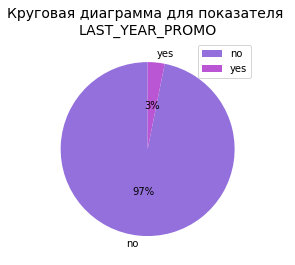

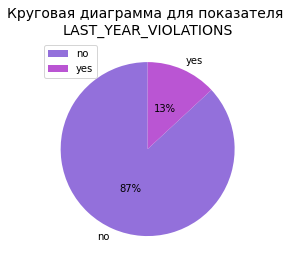

In [54]:
position = 0
plt.figure(figsize=[20,75]);
plt.subplots_adjust(wspace=0.5, hspace=1.0);

list = ['level','workload',  'last_year_promo', 'last_year_violations']


for name in list:
    position += 1
    df1 = test_1.pivot_table(index = name, values = 'id', aggfunc = 'count')
    df1.plot(
        kind = 'pie',
        subplots=True,
        autopct='%.0f%%',
        colors=['mediumpurple', 'mediumorchid', 'blueviolet'],
        startangle=90, 
        pctdistance=0.5
    );
    plt.title(f'Круговая диаграмма для показателя \n{name.upper()}', fontsize=14);
    plt.ylabel("");
    plt.show();

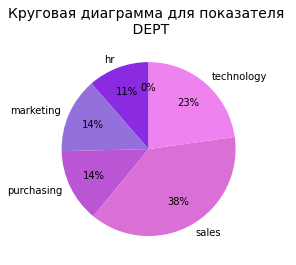

In [55]:
df1 = test_1.pivot_table(index = 'dept', values = 'id', aggfunc = 'count')
df1.plot(
    kind = 'pie'
    ,subplots=True
    ,autopct='%.0f%%'
    ,colors=[ 'darkviolet', 'blueviolet', 'mediumpurple', 'mediumorchid', 'orchid', 'violet']
    ,startangle=90
    ,pctdistance=0.7);
plt.title(f'Круговая диаграмма для показателя \n DEPT', fontsize=14);
plt.ylabel("");
plt.legend().remove();
plt.show();

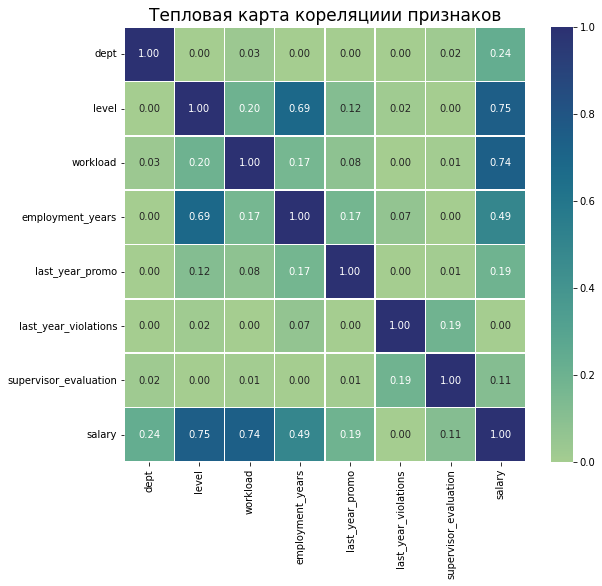

In [56]:
plt.figure(figsize=(9, 8));
sns.heatmap(
    test.phik_matrix(interval_cols=['salary'])
    ,annot = True
    ,fmt = '.2f'
    ,linewidth=.5
    ,cmap="crest"
);
plt.title('Тепловая карта кореляциии признаков', fontsize=17);

# ВЫВОД

Исходя из проведенного анализа следует, что:
- средний срок работы в компании составляет 3 года.Больше всего сотрудников работает 1 - 3 года. С увеличением роста срока работы уменьшаетя количество сотрудников.

- средняя зарплата сотрудников - около 30 тыс. руб. Зарплата среднего звена составляет 45 тыс. руб. Зарплаты выше 65 тыс. руб и выше относятся к сотрудникам высшего звена.

- уровень удовлетворенности сотрудника работой компании (среднее значение): 4

- больше всего сотрудников работает в отделе продаж: 38%, меньше всего в hr: 11%

- уровень junior имеет 47%, middle - 44%, уровень senior имеет 10%

- уровень нагрузки у сотрудников - средний(52%), высокую нагрузку имеют 18% сотрудников.

- повышение за прошлый год получило только 3% сотрудников (это негативно влияет на желание сотрудников на их работу в компании и профессиональное развитие)

- за последний год 14% сотрудников нарушело трудовой договор.

- корреляционный анализ показал, что целевой признак коррелирует с фактором оценки работы сотрудника руководством - 76%(это логично, поскольку влияет на продвижение по карьерной лестнице и увеличение зарплаты) и нарушением сотрудником трудового договора - 56% (возможно сотрудники не согласны с выговорами,которые они получают).

Исследовательский анализ данных для test выборки показал, что в данных нет существенных различий в части распределений признаков и что оценка модели, полученная на test выборке, будет корректной.

# ПОДГОТОВКА ДАННЫХ

На данном этапе необходимо:
1. разделить данные на тренировочную и тестовую выборки (предворительно обьединив данные test и target).
2. расписать какие данные к каким признакам относятся (перечни категориальных и количественных столбцов, списки для OneHotEncoder и OrdinalEncoder).
3. добавить OHE-кодирование в пайплайн (с заполнением пропусков).
4. добавить ORD-кодирование в пайплайн (с заполнением пропусков).
5. применить ColumnTransformer для объединения всех операций по подготовке данных.

In [57]:
print('количество дубликатов без id: ',train.duplicated().sum())
print('процентное соотношение :',round(train.duplicated().sum() / train.shape[0]* 100,1))

train = train.drop_duplicates()
print('число строк дубликатов после удаления :', train.duplicated().sum())

print('новое количество строк:' ,train.shape[0])

количество дубликатов без id:  245
процентное соотношение : 6.1
число строк дубликатов после удаления : 0
новое количество строк: 3755


In [58]:
test_all = test.join(target,on='id')

In [59]:
X_train =  train.drop(['job_satisfaction_rate'], axis=1)
X_test = test_all.drop(['job_satisfaction_rate'], axis=1)
y_train = train['job_satisfaction_rate']
y_test = test_all['job_satisfaction_rate']

X_train.shape, X_test.shape,y_train.shape,y_test.shape

((3755, 8), (2000, 8), (3755,), (2000,))

In [60]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

ord_columns = ['level', 'workload']

In [61]:
num_columns = ['employment_years','salary','supervisor_evaluation' ]

In [62]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first',handle_unknown='ignore', sparse_output=False)
        )
    ]
) 
ohe_pipe

Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))])

In [63]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories = [
                             ['junior', 'middle', 'sinior'],
                             ['low', 'medium', 'high']
                            ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 
ord_pipe

Pipeline(steps=[('simpleImputer_before_ord',
                 SimpleImputer(strategy='most_frequent')),
                ('ord',
                 OrdinalEncoder(categories=[['junior', 'middle', 'sinior'],
                                            ['low', 'medium', 'high']],
                                handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('simpleImputer_after_ord',
                 SimpleImputer(strategy='most_frequent'))])

# ВЫВОД

Был создан пайплайн подготовки данных.

Для данного пайплайна:
- количественные признаки employment_years, salary нужно отмасштабировать Standard или MinMax - какой из скейлеров использовать, определим при выборе лучшей модели. 
- признак 'dept'  нужно кодировать OneHotEncoder - это не ранговый признак. OneHotEncoder использвуем для кодирования признака 'last_year_promo'  и 'last_year_violations' - это бинарные признаки.
- признак 'level' кодируем с помощью OrdinalEncoder, т. к. значения признака можно ранжировать в порядке увеличения значимости: 'junior', 'middle', 'senior'.
- признак 'workload' кодируем с помощью OrdinalEncoder, т. к. это ранговый признак,значения которого увеличиваются: 'low', 'medium', 'high'.
- целевой признак кодировать и масштабировать не нужно, т. к. это количественный признак с непрерывным диапазоном значений [0,1].

 

# ОБУЧЕНИЕ МОДЕЛЕЙ
Будет использована модель DecisionTreeRegressor. Итоговый пайплайн - pipe_final. 
Он включает шаги:
- подготовка данных — preprocessor. 
- инициализация модели DecisionTreeRegressor —  models.

Задать метод масштабирования как гиперпараметр, чтобы перебирались методы StandardScaler() и MinMaxScaler().
Для автоматического подбора гиперпараметров будем использовать инструмент RandomizedSearchCV.

В словаре указать, какие варианты масштабирования будут перебираться: StandardScaler(), MinMaxScaler() и вариант без масштабирования.

Задать в качестве гиперпараметра модели, которые хотим использовать: DecisionTreeRegressor(), LinearRegression().
Для оценки качества работы модели будет использоваться метрика SMAPE («симметричное среднее абсолютное процентное отклонение»). 

Запуск с помощью автоматического подбора с помощью RandomizedSearchCV.

In [64]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [65]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [66]:
param = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(criterion = 'friedman_mse', random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 18), 
        'models__max_features': range(2, 18),
        'models__min_samples_split': range(2, 18),
        'models__min_samples_leaf': range(2, 18),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
     # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
]

In [67]:
def smape(y_test, y_pred):
    numerator = np.abs(y_pred - y_test)
    denominator = (np.abs(y_test)+np.abs(y_pred))/2
    smape_value = np.mean(numerator/denominator)*100
    return smape_value
    
smape_metrics = make_scorer(smape, greater_is_better = False)

In [68]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param, 
    scoring = smape_metrics,
    error_score= 'raise',
    n_iter=50,
    random_state=RANDOM_STATE, 
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

RandomizedSearchCV(error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violation...
                                         'models__max_features': range(2, 18),
                                         'models__min_samples_leaf': range(2, 18),
                                         'models__min_samples_split': range(2, 18),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [69]:
print('Метрика smape для лучшей модели:\n',- randomized_search.best_score_)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 

Метрика smape для лучшей модели:
 15.325198497106248
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                

In [70]:
warnings.simplefilter("ignore")

In [71]:
y_test_pred = randomized_search.predict(X_test)
print('Метрика smape на тестовой выборке:', smape(y_test, y_test_pred));

Метрика smape на тестовой выборке: 13.516016715410858


# Вывод
Было обучено 2 модели:
- дерево решений 
- линейная регрессия.

В качестве гипарпараметров использовали методы масштабирования, для автоматического подбора гиперпараметров использовали инструмент RandomizedSearchCV.

Для оценки работы модели была создана метрика SMAPE («симметричное среднее абсолютное процентное отклонение»).

По итогам подбора лучшей моделью стала модель DecisionTreeRegressor со следующими параметрами:
- criterion='friedman_mse', 
- max_depth=17, 
- max_features=11, 
- min_samples_leaf=4, 
- min_samples_split=4,
- random_state=42. 

Метрика SMAPE на тестовой выборке - 13,5%.

# ЗАДАЧА 2. Предсказание увольнения сотрудника из компании

Задачи:
- Загрузить данные из файлов train_job_satisfaction_rate.csv, test_features.csv, test_target_quit.csv, подготовить данные для последующего анализа.
- При необходимости выполнить предобработку. При наличии пропущенных значений заполнить их в пайплайне.
- Провести исследовательский анализ данных.
- Составить портрет «уволившегося сотрудника». Узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.
- Проверить утверждение, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Визуализировать и сравнить распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников.
- Добавить новый признак job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.
- Выполните подготовку признаков в пайплайне, дополнив пайплайн предобработки. При кодировании учесть особенности признаков и моделей, использовать как минимум два кодировщика.
- Обучить три модели, как минимум для двух из них подобрать гиперпараметры. Проверить качество лучшей модели с помощью метрики ROC-AUC (критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке).
- Сделать и аргументировать промежуточные выводы о том, какая модель справилась лучше.

# ЗАГРУЗКА ДАННЫХ
На начальном этапе работы с данными необходимо провести загруску данных из предоставленных файлов и посмотреть общую информацию по данным файлам. После просмотра сделать соответствующие выводы, касаемо преобработки данных

In [72]:
train_new = pd.read_csv('/datasets/train_quit.csv')

In [73]:
display(train_new.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 100954 to 999521
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3749 non-null   object 
 1   level                  3751 non-null   object 
 2   workload               3755 non-null   object 
 3   employment_years       3755 non-null   int64  
 4   last_year_promo        3755 non-null   object 
 5   last_year_violations   3755 non-null   object 
 6   supervisor_evaluation  3755 non-null   int64  
 7   salary                 3755 non-null   int64  
 8   job_satisfaction_rate  3755 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 293.4+ KB


In [75]:
test_new = test

In [76]:
display(test_new.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


In [77]:
target_new = pd.read_csv('/datasets/test_target_quit.csv')

In [78]:
display(target_new.head())

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [79]:
target_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


# Вывод
После загрузки данных и первичного просмотра файла было установлено, что:
1. во всех данных корректно было введено название колон
2. всем данным корректно присвоен тип данных.

В предобработке данные неоходимо проверить на пропуски и дубликаты. Данные test обрабатывать нет необходимости, поскольку это было сделано в первой задаче.

# ПРЕДОБРАБОТКА ДАННЫХ
На данном этапе необходимо все данные проверить на наличие дубликатов и пропусков и по возможности сделать замену, если это возможно, удалить(если это не сильно скажется на данных) или оставить без именений.

## работа с данными train_new

In [80]:
print(train_new.isna().sum())

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64


In [81]:
print('количество строк в данных: ',train_new.shape[0])

количество строк в данных:  4000


In [82]:
train_new = train_new.sort_values(by = 'id')
train_new = train_new.set_index('id')
display(train.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100954,purchasing,junior,low,1,no,no,4,15600,0.60
101057,sales,junior,low,1,no,yes,4,19200,0.45
101074,sales,junior,medium,2,no,no,2,20400,0.36
101081,sales,middle,low,2,no,no,4,28800,0.66
101129,technology,junior,medium,1,no,no,4,34800,0.71


In [83]:
print ('уникальные значения столбца dept :',train_new['dept'].unique())
print ('уникальные значения столбца level :',train_new['level'].unique())
print ('уникальные значения столбца workload :',train_new['workload'].unique())
print ('уникальные значения столбца last_year_promo :',train_new['last_year_promo'].unique())
print ('уникальные значения столбца last_year_violations :',train_new['last_year_violations'].unique())
print ('уникальные значения столбца supervisor_evaluation :',train_new['supervisor_evaluation'].unique())

уникальные значения столбца dept : ['sales' 'purchasing' 'marketing' 'technology' 'hr']
уникальные значения столбца level : ['junior' 'middle' 'sinior']
уникальные значения столбца workload : ['medium' 'high' 'low']
уникальные значения столбца last_year_promo : ['no' 'yes']
уникальные значения столбца last_year_violations : ['no' 'yes']
уникальные значения столбца supervisor_evaluation : [2 3 4 1 5]


## вывод
После преобоработки данного файла было сделано:
1. в данных был убран столбец с id, он стал порядком строки. Также данные были отсортированы по возростанию id.
2. поиск дубликатов без id = 1413, что составляет 35.3% от всех данных. Было принято решение их удалить, когд абудет проходить подготовка данных к моделированию.
5. после проверки на уникальность данных была обнаружена неправильная записать 'sinior' в колоне 'level'. Этот дефект будет изменен в пайплайне.

Количество строк: 4000

## работа с данными target_new

In [84]:
print(target_new.isna().sum())

id      0
quit    0
dtype: int64


In [85]:
print('количество строк в данных: ',target_new.shape[0])

количество строк в данных:  2000


In [86]:
display(test_new.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


In [87]:
target_new = target_new.sort_values(by = 'id')
target_new = target_new.set_index('id')
display(target_new.head())

,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no


## вывод

Предобработка данных не потребовалась.

Данные были отсортированы по возрастанию значений id

Количество строк: 2000

# Вывод
В предобработке данных каждый файл просматривался на наличие пропусков и дубликатов.

В данных train было сделано:
1. в данных был убран столбец с id, он стал порядком строки. Также данные были отсортированы по возростанию id.
2. поиск дубликатов без id = 1413, что составляет 35.3% от всех данных. Было принято решение их удалить, когд абудет проходить подготовка данных к моделированию.
5. после проверки на уникальность данных была обнаружена неправильная записать 'sinior' в колоне 'level'. Этот дефект будет изменен в пайплайне.

Количество строк: 4000

В данных test предобработка на потребовалась, поскольку данные были взяты из задачи 1.

Предобработка данных в target не потребовалась.Данные были отсортированы по возрастанию значений id.

Количество строк: 2000


# ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ

# Исследовательский анализ данных.
Необходимо провести исследовательский анализ данных train_new

In [88]:
train_2 = train_new.reset_index()

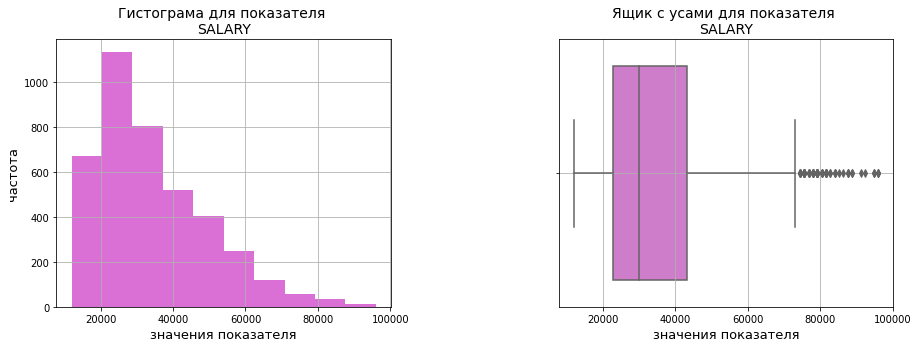

In [89]:
position = 0
plt.figure(figsize=[15,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'salary'
]

for name in list:
    position += 1
    
    df1 = train_2[name]
    plt.subplot(4, 2, position)
    df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Гистограма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = train_2[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

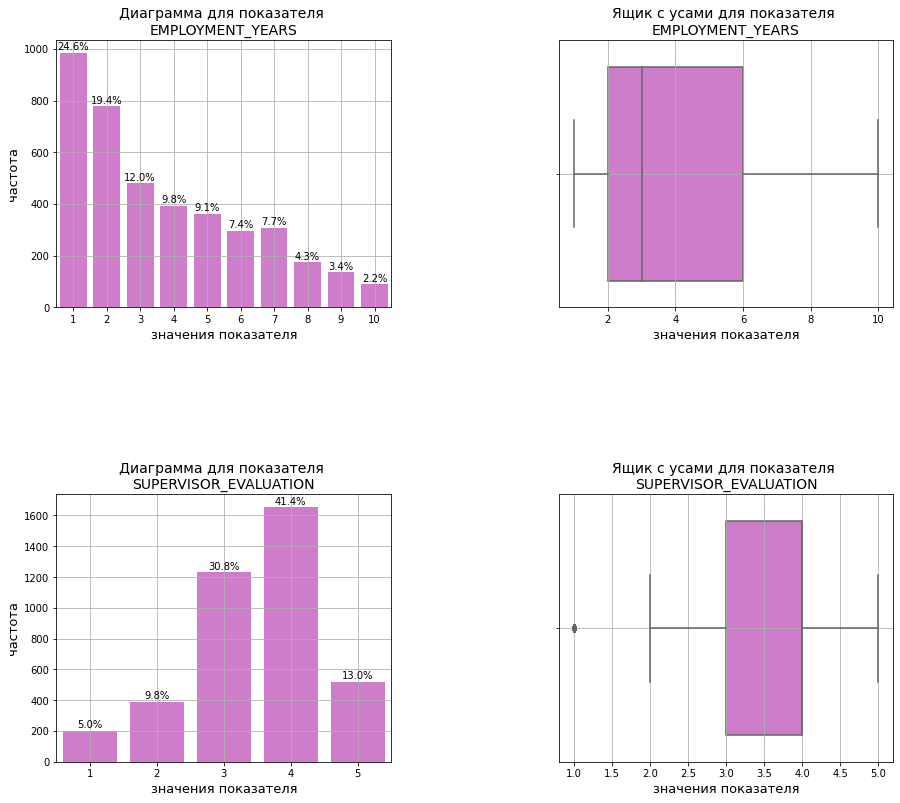

In [90]:
position = 0
plt.figure(figsize=[15,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'employment_years', 
    'supervisor_evaluation'
]

for name in list:
    position += 1
    
    df1 = train_2[name]
    plt.subplot(4, 2, position)
    ax = sns.countplot(x = name, data =train_2, color = 'orchid')
    plt.title(f'Диаграмма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    for p in ax.patches:
        # print(p.get_facecolor(), p.get_label())
        percentage = f'{100 * p.get_height() / len(df1):.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    
    position += 1
    df2 = train_2[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

In [91]:
display(train_2.query('supervisor_evaluation == 1'))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
12,102639,purchasing,junior,low,1,no,no,1,15600,yes
26,106460,sales,junior,medium,1,no,no,1,20400,yes
34,107616,technology,junior,medium,1,no,yes,1,30000,yes
41,108144,sales,junior,medium,1,no,no,1,24000,yes
58,111442,technology,junior,low,1,no,no,1,18000,yes
...,...,...,...,...,...,...,...,...,...,...
3923,983352,sales,junior,medium,3,no,no,1,26400,no
3937,986840,sales,middle,high,10,no,no,1,50400,no
3987,996445,sales,junior,low,2,no,no,1,12000,yes
3992,997272,hr,junior,medium,1,no,no,1,25200,yes


In [92]:
list = [ 
    'employment_years', 
    'supervisor_evaluation',
    'salary' 
]

for name in list:
    df1 = train_1[name]
    print(f'Характеристики количественного показателя {name.upper()}')
    print(df1.describe(),'\n')

Характеристики количественного показателя EMPLOYMENT_YEARS
count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64 

Характеристики количественного показателя SUPERVISOR_EVALUATION
count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64 

Характеристики количественного показателя SALARY
count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64 



<Figure size 1440x5400 with 0 Axes>

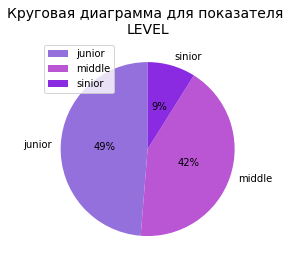

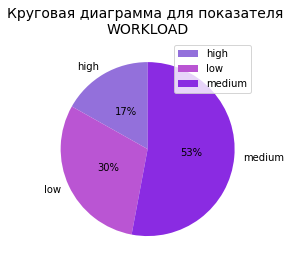

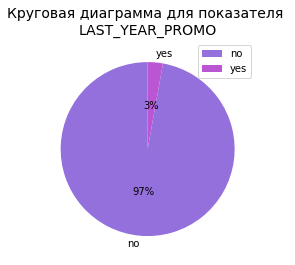

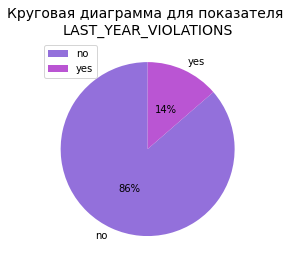

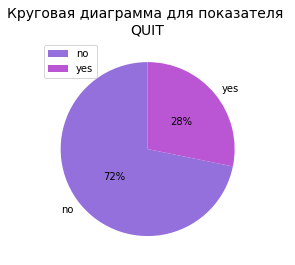

In [93]:
position = 0
plt.figure(figsize=[20,75]);
plt.subplots_adjust(wspace=0.5, hspace=1.0);

list = ['level','workload',  'last_year_promo', 'last_year_violations', 'quit']


for name in list:
    position += 1
    df1 = train_2.pivot_table(index = name, values = 'id', aggfunc = 'count')
    df1.plot(
        kind = 'pie',
        subplots=True,
        autopct='%.0f%%',
        colors=['mediumpurple', 'mediumorchid', 'blueviolet'],
        startangle=90, 
        pctdistance=0.5
    );
    plt.title(f'Круговая диаграмма для показателя \n{name.upper()}', fontsize=14);
    plt.ylabel("");
    plt.show();

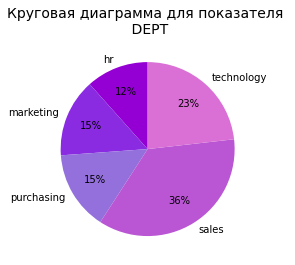

In [94]:
df1 = train_2.pivot_table(index = 'dept', values = 'id', aggfunc = 'count')
df1.plot(
    kind = 'pie'
    ,subplots=True
    ,autopct='%.0f%%'
    ,colors=[ 'darkviolet', 'blueviolet', 'mediumpurple', 'mediumorchid', 'orchid', 'violet']
    ,startangle=90
    ,pctdistance=0.7);
plt.title(f'Круговая диаграмма для показателя \n DEPT', fontsize=14);
plt.ylabel("");
plt.legend().remove();
plt.show();

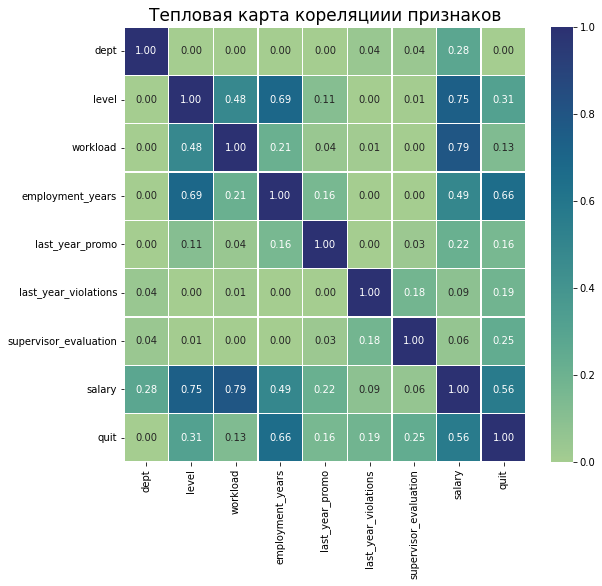

In [95]:
plt.figure(figsize=(9, 8));
sns.heatmap(
    train_new.phik_matrix(interval_cols=['salary'])
    ,annot = True
    ,fmt = '.2f'
    ,linewidth=.5
    ,cmap="crest"
);
plt.title('Тепловая карта кореляциии признаков', fontsize=17);

## вывод
Исходя из проведенного анализа следует, что:
- средний срок работы в компании составляет 3 года.Больше всего сотрудников работает 1 - 3 года. С увеличением роста срока работы уменьшаетя количество сотрудников.

- средняя зарплата сотрудников - около 30 тыс. руб. Зарплата среднего звена составляет 45 тыс. руб. Зарплаты выше 65 тыс. руб и выше относятся к сотрудникам высшего звена.

- уровень удовлетворенности сотрудника работой компании (среднее значение): 4

- больше всего сотрудников работает в отделе продаж: 31%, меньше всего в hr: 13%

- уровень junior - 49%, middle - 42%, уровень senior имеет 9%

- уровень нагрузки у сотрудников - средний(53%), высокую нагрузку имеют 17% сотрудников.

- повышение за прошлый год получило только 3% сотрудников (это негативно влияет на желание сотрудников на их работу в компании и профессиональное развитие)

- за последний год 14% сотрудников нарушело трудовой договор.

- увольнение составляет 28% от всего количества сострудников.

- корреляционный анализ показал, что целевой признак коррелирует с фактором длительности работы сотрудника в компании - 66% и ежемесячной зарплатой сотрудника - 56%.

## Составление портрета уволившегося сотрудника

In [96]:
train_out = train_new.query('quit == "yes"')
display(train_out.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes
100459,purchasing,junior,medium,3,no,no,3,21600,yes
100858,sales,junior,medium,2,no,no,4,25200,yes
100969,marketing,junior,medium,2,no,no,3,26400,yes
102630,technology,junior,medium,2,no,no,2,30000,yes


In [97]:
train_on = train_new.query('quit == "no"')
display(train_on.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
100469,marketing,junior,medium,1,no,no,4,28800,no
100601,technology,middle,high,4,no,no,4,68400,no
101047,purchasing,junior,medium,3,no,no,4,26400,no
101374,technology,middle,low,8,no,no,3,22800,no
102155,technology,middle,high,8,no,no,4,57600,no


In [98]:
train_out = train_out.reset_index()

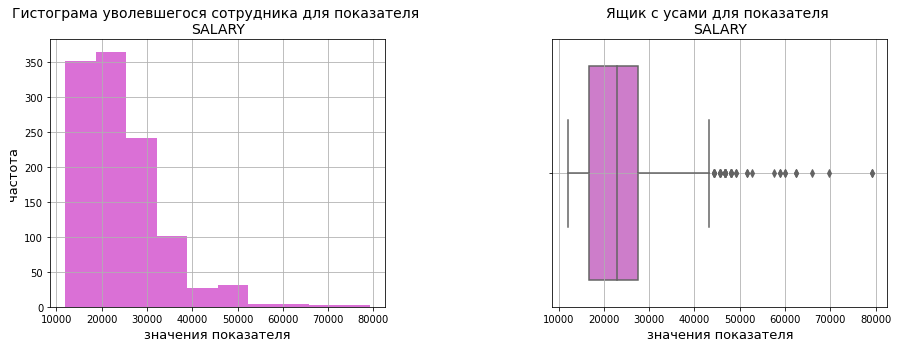

In [99]:
position = 0
plt.figure(figsize=[15,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'salary'
]

for name in list:
    position += 1
    
    df1 = train_out[name]
    plt.subplot(4, 2, position)
    df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Гистограма уволевшегося сотрудника для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = train_out[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

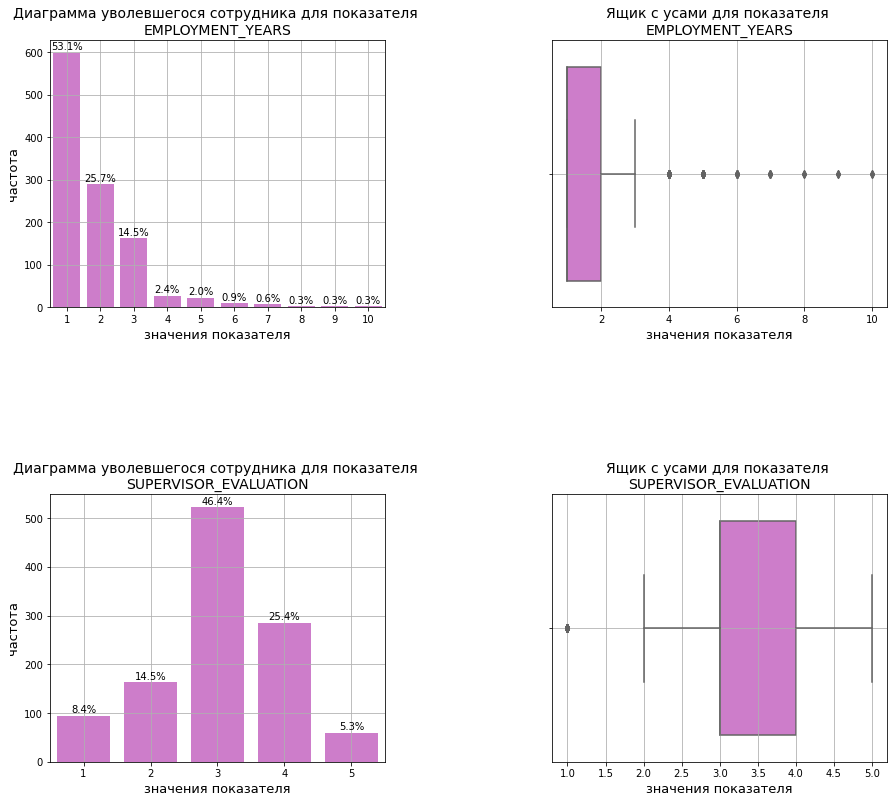

In [100]:
position = 0
plt.figure(figsize=[15,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'employment_years', 
    'supervisor_evaluation'
]

for name in list:
    position += 1
    
    df1 = train_out[name]
    plt.subplot(4, 2, position)
    ax = sns.countplot(x = name, data =train_out, color = 'orchid')
    #df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Диаграмма уволевшегося сотрудника для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    for p in ax.patches:
        # print(p.get_facecolor(), p.get_label())
        percentage = f'{100 * p.get_height() / len(df1):.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    
    position += 1
    df2 = train_out[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

In [101]:
list = [ 
    'employment_years', 
    'supervisor_evaluation',
    'salary' 
]

for name in list:
    df1 = train_out[name]
    print(f'Характеристики количественного показателя для уволившегося сотрудника {name.upper()}')
    print(df1.describe(),'\n')

Характеристики количественного показателя для уволившегося сотрудника EMPLOYMENT_YEARS
count    1128.000000
mean        1.844858
std         1.274920
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: employment_years, dtype: float64 

Характеристики количественного показателя для уволившегося сотрудника SUPERVISOR_EVALUATION
count    1128.000000
mean        3.046099
std         0.973291
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64 

Характеристики количественного показателя для уволившегося сотрудника SALARY
count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64 



<Figure size 1440x5400 with 0 Axes>

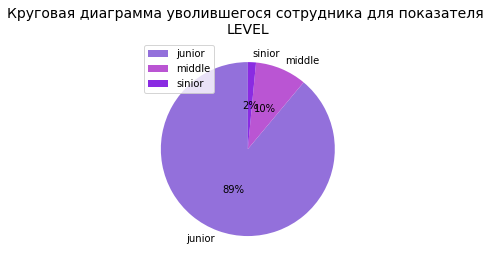

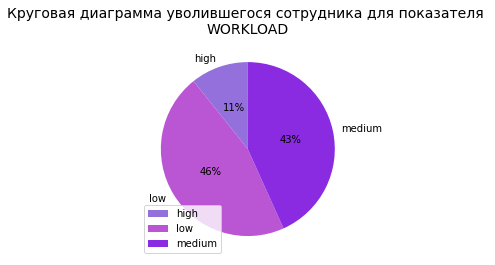

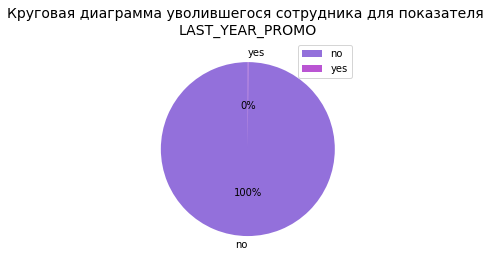

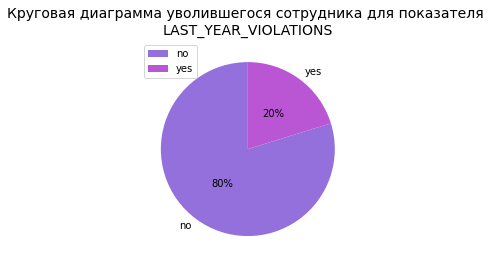

In [102]:
position = 0
plt.figure(figsize=[20,75]);
plt.subplots_adjust(wspace=0.5, hspace=1.0);

list = ['level','workload','last_year_promo','last_year_violations']


for name in list:
    position += 1
    df1 = train_out.pivot_table(index = name, values = 'id', aggfunc = 'count')
    df1.plot(
        kind = 'pie',
        subplots=True,
        autopct='%.0f%%',
        colors=['mediumpurple', 'mediumorchid', 'blueviolet'],
        startangle=90, 
        pctdistance=0.5
    );
    plt.title(f'Круговая диаграмма уволившегося сотрудника для показателя \n{name.upper()}', fontsize=14);
    plt.ylabel("");
    plt.show();

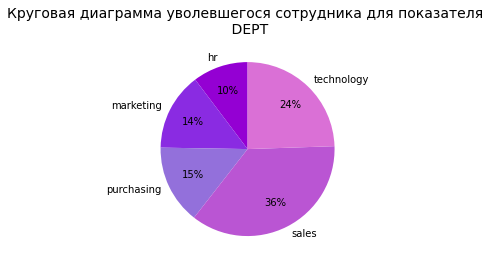

In [103]:
df1 = train_out.pivot_table(index = 'dept', values = 'id', aggfunc = 'count')
df1.plot(
    kind = 'pie'
    ,subplots=True
    ,autopct='%.0f%%'
    ,colors=[ 'darkviolet', 'blueviolet', 'mediumpurple', 'mediumorchid', 'orchid', 'violet']
    ,startangle=90
    ,pctdistance=0.7);
plt.title(f'Круговая диаграмма уволевшегося сотрудника для показателя \n DEPT', fontsize=14);
plt.ylabel("");
plt.legend().remove();
plt.show();

In [104]:
train_on = train_on.reset_index()

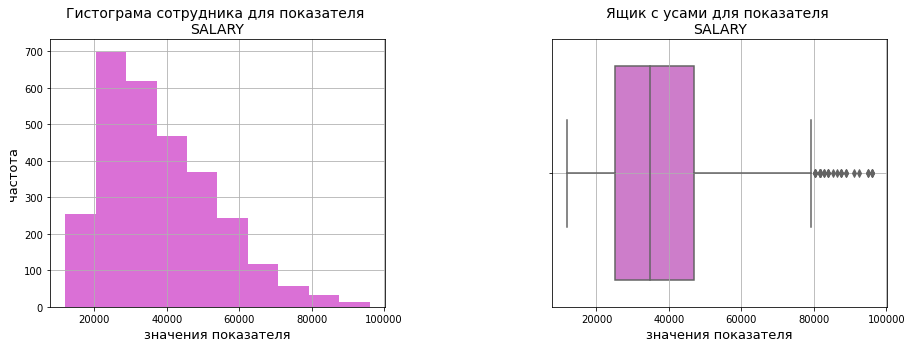

In [105]:
position = 0
plt.figure(figsize=[15,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'salary'
]

for name in list:
    position += 1
    
    df1 = train_on[name]
    plt.subplot(4, 2, position)
    df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Гистограма сотрудника для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = train_on[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

In [106]:
import matplotlib.pyplot as plt

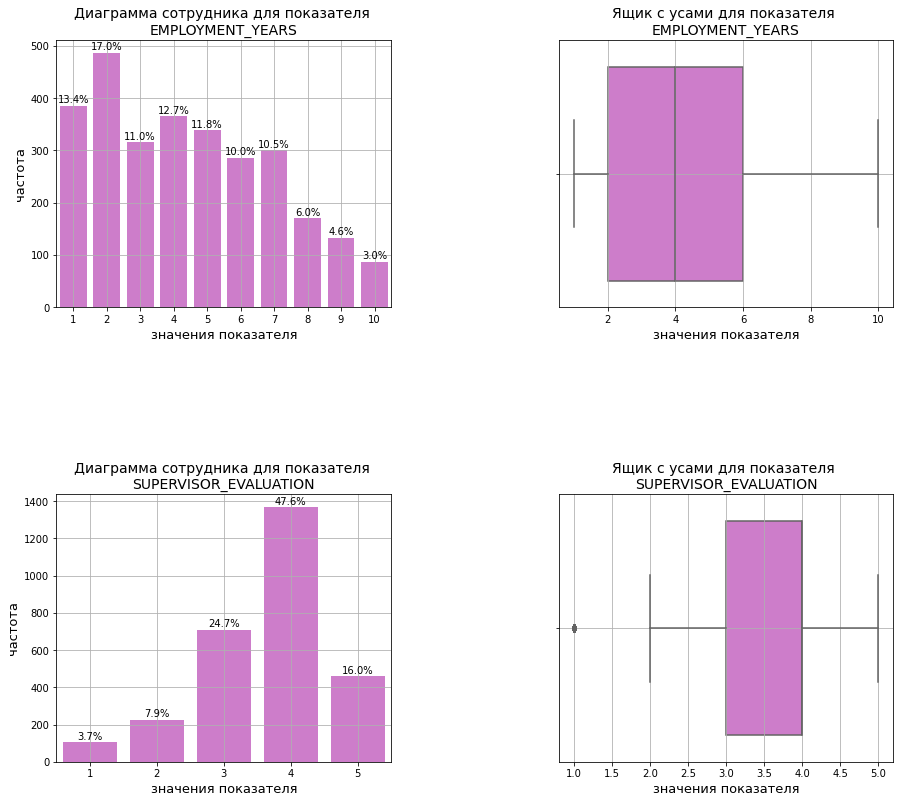

In [107]:
position = 0
plt.figure(figsize=[15,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'employment_years', 
    'supervisor_evaluation'
]

for name in list:
    position += 1
    
    df1 = train_on[name]
    plt.subplot(4, 2, position)
    ax = sns.countplot(x = name, data =train_on, color = 'orchid')
    #df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Диаграмма сотрудника для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    for p in ax.patches:
        # print(p.get_facecolor(), p.get_label())
        percentage = f'{100 * p.get_height() / len(df1):.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    
    position += 1
    df2 = train_on[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);
    

In [108]:
list = [ 
    'employment_years', 
    'supervisor_evaluation',
    'salary' 
]

for name in list:
    df1 = train_on[name]
    print(f'Характеристики количественного показателя для сотрудника {name.upper()}')
    print(df1.describe(),'\n')

Характеристики количественного показателя для сотрудника EMPLOYMENT_YEARS
count    2872.000000
mean        4.430710
std         2.544635
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64 

Характеристики количественного показателя для сотрудника SUPERVISOR_EVALUATION
count    2872.000000
mean        3.643106
std         0.965295
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64 

Характеристики количественного показателя для сотрудника SALARY
count     2872.000000
mean     37702.228412
std      15218.977339
min      12000.000000
25%      25200.000000
50%      34800.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64 



<Figure size 1440x5400 with 0 Axes>

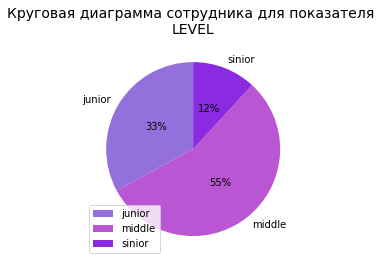

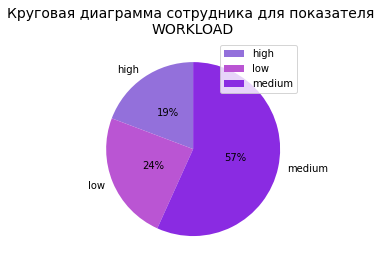

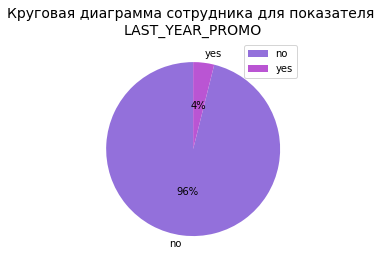

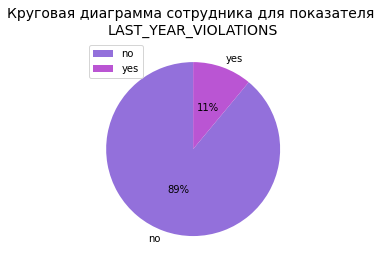

In [109]:
position = 0
plt.figure(figsize=[20,75]);
plt.subplots_adjust(wspace=0.5, hspace=1.0);

list = ['level','workload',  'last_year_promo', 'last_year_violations']


for name in list:
    position += 1
    df1 = train_on.pivot_table(index = name, values = 'id', aggfunc = 'count')
    df1.plot(
        kind = 'pie',
        subplots=True,
        autopct='%.0f%%',
        colors=['mediumpurple', 'mediumorchid', 'blueviolet'],
        startangle=90, 
        pctdistance=0.5
    );
    plt.title(f'Круговая диаграмма сотрудника для показателя \n{name.upper()}', fontsize=14);
    plt.ylabel("");
    plt.show();

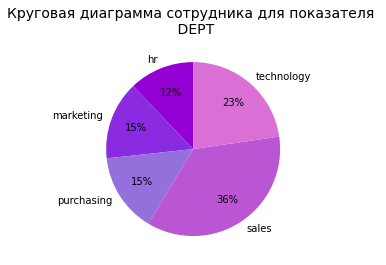

In [110]:
df1 = train_on.pivot_table(index = 'dept', values = 'id', aggfunc = 'count')
df1.plot(
    kind = 'pie'
    ,subplots=True
    ,autopct='%.0f%%'
    ,colors=[ 'darkviolet', 'blueviolet', 'mediumpurple', 'mediumorchid', 'orchid', 'violet']
    ,startangle=90
    ,pctdistance=0.7);
plt.title(f'Круговая диаграмма сотрудника для показателя \n DEPT', fontsize=14);
plt.ylabel("");
plt.legend().remove();
plt.show();

## Вывод
Портрет уволевшегося сотрудника:
- средний срок работы - 2 года (работающего сотрудника - 5 лет).
- средняя ежемесячная зарплата - 25 тыщ. руб (у работающего - 40 тыщ. руб)
- в основном низная загруженность - 46% (в отличие от работающий, у них средняя загрузка 57%)
- уровень junior - 89% (у работающий middle 55%)
- нет повышения за последний год 0% (у работяющих 4%)
- 20% нарушений трудового договора (у работающих 11%)
- максимальный процент увольнения в sales - 36% (у работающий это также максимальный процент, то есть в данном отделе польшая текучка кадров)

По полученному портрету можно сделать вывод, что людт уходят из фирмы из-за низких заработных плат, отсутсвие повышения, низкой загрузкой.

## Проверка утверждения, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник

In [111]:
target_all = pd.merge(target, target_new, on = 'id', how = 'outer')
display(target_all.head())

,job_satisfaction_rate,quit
id,,
100298,0.80,no
100480,0.84,no
100503,0.79,no
100610,0.75,no
100692,0.69,no


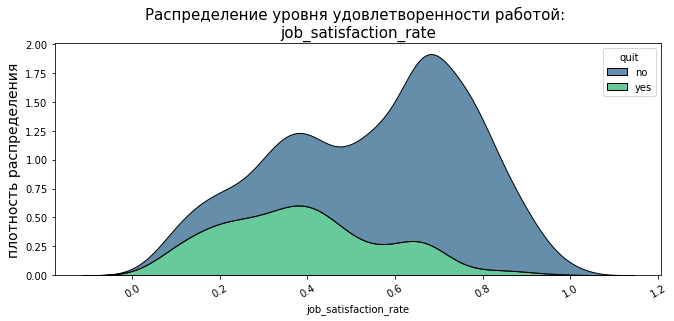

In [112]:
position = 0
plt.figure(figsize=[25,100])
plt.subplots_adjust(wspace=0.3, hspace=0.6)
columns = [
    'job_satisfaction_rate'
]

for col in columns:
    position += 1
    plt.subplot(15, 2, position)
    sns.kdeplot(data=target_all, x=col, hue='quit', multiple="stack", palette='viridis')
    #sns.histplot(target_all, bins=25, hue='quit', x=col,palette='viridis');
    plt.title(f'Распределение уровня удовлетворенности работой: \n{col}', fontsize=15);
    plt.xticks( rotation=30)
    plt.ylabel('плотность распределения',fontsize=14);

Для проверки зависимости уровня удовлетворенности от статуса сотрудника построим гипотезу и проверим её.

Гипотеза: средние значения уровня удовлетворенности у уволившегося и работающего сотрудника одинаковые.

Для проверки данной гипотезы воспользуемся t-критерием для подтверждения гипотезы о равенстве средних двух генеральных совокупностей.

Пороговое значение p-value = 0.05 (общепринятое)

Формулировка гипотезы:

- H0(нулевая гипотеза) - средние значения уровня удовлетворенности у уволившегося и работающего сотрудника одинаковые.

- H1(альтернативная гипотеза) - средние значения уровня удовлетворенности у уволившегося и работающего сотрудника разные.

Альтернативное решение такого вида было выбрано, поскольку интересует только наличия равенства.

In [113]:
alpha = 0.05

no = target_all.query('quit == "no"') 
yes = target_all.query('quit == "yes"') 

results = st.ttest_ind(yes['job_satisfaction_rate'], no['job_satisfaction_rate'])

print(f' p-value: {results.pvalue}')

if results.pvalue < alpha :
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Нет оснований отвергнуть нулевую гипотезу')
    


print('\nСреднее для работающих сотрудников: ', round(yes['job_satisfaction_rate'].mean(),2))
print('Среднее для уволенных сотрудников: ', round(no['job_satisfaction_rate'].mean(),2))

 p-value: 1.231122066517193e-104
Отвергаем нулевую гипотезу

Среднее для работающих сотрудников:  0.39
Среднее для уволенных сотрудников:  0.61


## вывод
Уровень удовлетворенности сотрудником работы компанией зависит от статуса работника: уволенный или работающий. У работающих сотрудников уровень удовлетворенности в составляет в среднем 61%, у уволенных в среднем составляет 39%.

# ВЫВОД

Исходя из проведенного анализа следует, что:
- средний срок работы в компании составляет 3 года.Больше всего сотрудников работает 1 - 3 года. С увеличением роста срока работы уменьшаетя количество сотрудников.

- средняя зарплата сотрудников - около 30 тыс. руб. Зарплата среднего звена составляет 45 тыс. руб. Зарплаты выше 65 тыс. руб и выше относятся к сотрудникам высшего звена.

- уровень удовлетворенности сотрудника работой компании (среднее значение): 4

- больше всего сотрудников работает в отделе продаж: 31%, меньше всего в hr: 13%

- уровень junior - 49%, middle - 42%, уровень senior имеет 9%

- уровень нагрузки у сотрудников - средний(53%), высокую нагрузку имеют 17% сотрудников.

- повышение за прошлый год получило только 3% сотрудников (это негативно влияет на желание сотрудников на их работу в компании и профессиональное развитие)

- за последний год 14% сотрудников нарушело трудовой договор.

- увольнение составляет 28% от всего количества сострудников.

- корреляционный анализ показал, что целевой признак коррелирует с фактором длительности работы сотрудника в компании - 66% и ежемесячной зарплатой сотрудника - 56%.

Портрет уволевшегося сотрудника:
Портрет уволевшегося сотрудника:
- средний срок работы - 2 года (работающего сотрудника - 5 лет).

- средняя ежемесячная зарплата - 25 тыщ. руб (у работающего - 40 тыщ. руб)

- в основном низная загруженность - 46% (в отличие от работающий, у них средняя загрузка 57%)

- уровень junior - 89% (у работающий middle 55%)

- нет повышения за последний год 0% (у работяющих 4%)

- 20% нарушений трудового договора (у работающих 11%)

- максимальный процент увольнения в sales - 36% (у работающий это также максимальный процент, то есть в данном отделе польшая текучка кадров)

По полученному портрету можно сделать вывод, что людт уходят из фирмы из-за низких заработных плат, отсутсвие повышения, низкой загрузкой.

Уровень удовлетворенности сотрудником работы компанией зависит от статуса работника: уволенный или работающий. У работающих сотрудников уровень удовлетворенности в составляет в среднем 61%, у уволенных в среднем составляет 39%.

# ДОБАВЛЕНИЕ НОВОГО ВХОДНОГО ПРИЗНАКА
На данном этапе необходимо добавить job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи. Для этого необходимо:
- удалить дубликаты в train_new
- убрать признак quit,(его не было во входных признаках модели из перой задачи)
- сделать предсказания признака job_satisfaction_rate на данных train_new с помощью лучшей модели из первой задачи
- добавить полученный прогноз в test_new и train_new

In [114]:
print('количество дубликатов без id: ',train_new.duplicated().sum())
print('процентное соотношение :',round(train_new.duplicated().sum() / train_new.shape[0]* 100,1))
train_new = train_new.drop_duplicates()
print('число строк дубликатов после удаления :', train_new.duplicated().sum())
print('новое количество строк:' ,train_new.shape[0])

количество дубликатов без id:  1413
процентное соотношение : 35.3
число строк дубликатов после удаления : 0
новое количество строк: 2587


In [115]:
train_end = train_new.drop(['quit'], axis=1)
display(train_end.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400
100459,purchasing,junior,medium,3,no,no,3,21600
100469,marketing,junior,medium,1,no,no,4,28800
100601,technology,middle,high,4,no,no,4,68400
100858,sales,junior,medium,2,no,no,4,25200


In [116]:
job_pred = randomized_search.predict(train_end)

In [117]:
train_new['job_pred'] = job_pred
#train_new = train_end
display(train_new.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_pred
id,,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes,0.345714
100459,purchasing,junior,medium,3,no,no,3,21600,yes,0.311667
100469,marketing,junior,medium,1,no,no,4,28800,no,0.654444
100601,technology,middle,high,4,no,no,4,68400,no,0.670000
100858,sales,junior,medium,2,no,no,4,25200,yes,0.837273


In [118]:
job_pred_test = randomized_search.predict(test_new)

In [119]:
test_new['job_pred'] = job_pred_test
display(test_new.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_pred
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.820
100480,marketing,junior,low,4,no,no,4,16800,0.852
100503,purchasing,middle,high,5,no,no,4,55200,0.806
100610,sales,middle,medium,5,no,no,4,43200,0.810
100692,sales,middle,high,6,no,no,4,48000,0.696


# ВЫВОД
В тренировочную выборку train_new был добавлен прогноз job_satisfaction_rate, полученный с помощью лучшей модели первой задачи.

# ПОДГОТОВКА ДАННЫХ
На данном этапе необходимо:
1. разделить данные на тренировочную и тестовую выборки.
2. расписать какие данные к каким признакам относятся (перечни категориальных и количественных столбцов, списки для OneHotEncoder и OrdinalEncoder).
3. добавить OHE-кодирование в пайплайн (с заполнением пропусков).
4. добавить ORD-кодирование в пайплайн (с заполнением пропусков).
5. применить ColumnTransformer для объединения всех операций по подготовке данных.

In [120]:
X_train_new = train_new.drop(['quit'], axis=1)
y_train_new= train_new['quit']

X_test_new= test_new
y_test_new = target_new['quit']

In [121]:
le = LabelEncoder()
le.fit(y_train_new)

y_train_new = le.transform(y_train_new)
y_test_new = le.transform(y_test_new) 

In [122]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

ord_columns = ['level', 'workload']

num_columns = ['employment_years', 'salary', 'job_pred','supervisor_evaluation' ]

In [123]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
) 

In [124]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories = [
                             ['junior', 'middle', 'sinior'],
                             ['low', 'medium', 'high'],
                            ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [125]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

# ВЫВОД
Был создан пайплайн подготовки данных.

Для данного пайплайна:
- количественные признаки employment_years, salary нужно отмасштабировать Standard или MinMax - какой из скейлеров использовать, определим при выборе лучшей модели. 
- признак 'dept'  нужно кодировать OneHotEncoder - это не ранговый признак. OneHotEncoder использвуем для кодирования признака 'last_year_promo'  и 'last_year_violations' - это бинарные признаки.
- признак 'level' кодируем с помощью OrdinalEncoder, т. к. значения признака можно ранжировать в порядке увеличения значимости: 'junior', 'middle', 'sinior'.
- признак 'workload' кодируем с помощью OrdinalEncoder, т. к. это ранговый признак,значения которого увеличиваются: 'low', 'medium', 'high'.

# ОБУЧЕНИЕ МОДЕЛИ
Будет использована модель DecisionTreeRegressor. Итоговый пайплайн - pipe_final. 
Он включает шаги:
- подготовка данных —  preprocessor. 
- инициализация модели DecisionTreeClassifier —  models.

Задать метод масштабирования как гиперпараметр, чтобы перебирались методы StandardScaler() и MinMaxScaler().
Для автоматического подбора гиперпараметров будем использовать инструмент RandomizedSearchCV.

В словаре указать, какие варианты масштабирования будут перебираться: StandardScaler(), MinMaxScaler() и вариант без масштабирования.

Задать в качестве гиперпараметра модели, которые хотим использовать: DecisionTreeClassifier(), KNeighborsClassifier(),LogisticRegression.
Для оценки качества работы модели будет использоваться метрика roc_auc. 

Запуск с помощью автоматического подбора с помощью RandomizedSearchCV.

In [126]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
) 

In [127]:
param_rs = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7), 
        'models__max_features': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
   
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 25),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression
        (
         random_state=RANDOM_STATE, 
            solver='liblinear',
            class_weight='balanced',
            penalty='l1'
        )
                  ],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
]

In [128]:
randomized_search_2 = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_rs, 
    error_score= 'raise',
    scoring = 'roc_auc',
    cv=5,
    n_iter=50,
    random_state=RANDOM_STATE, 
    n_jobs=-1
)
randomized_search_2.fit(X_train_new, y_train_new) 

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 25),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(class_weight='balanced',
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [129]:
print('Метрика ROC_AUC для лучшей модели:\n', randomized_search_2.best_score_)
print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_) 

Метрика ROC_AUC для лучшей модели:
 0.9076298216335783
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleI

In [130]:
y_test_pred_new = randomized_search_2.predict_proba(X_test_new)
y_test_pred_one = y_test_pred_new[:, 1]
print('Метрика ROC-AUC на тестовой выборке:', roc_auc_score(y_test_new, y_test_pred_one))

Метрика ROC-AUC на тестовой выборке: 0.9146874197435745


In [131]:
dummy_clf = DummyClassifier(strategy='most_frequent')

In [132]:
dummy_clf.fit(X_train_new, y_train_new)

DummyClassifier(strategy='most_frequent')

In [133]:
y_pred = dummy_clf.predict(X_test_new)
ac = accuracy_score(y_test_new, y_pred)
print(f"Метрика DummyClassifier: {ac*100}%")

Метрика DummyClassifier: 71.8%


# ВЫВОД

Было обучено 3 модели:
- DecisionTreeClassifier() 
- KNeighborsClassifier()
- LogisticRegression

В качестве гипарпараметров использовали методы масштабирования, для автоматического подбора гиперпараметров использовали инструмент RandomizedSearchCV.

Для оценки работы модели была создана метрика ROC AUC.

По итогам подбора лучшей моделью стала модель KNeighborsClassifier() со следующими параметрами:
- n_neighbors=21. 

Метрика ROC  AUC на тестовой выборке - 91,5%.

Была проведена проверка с помощью DummyClassifier.
Метрика DummyClassifier: 71.8%. Модель построена корректно.

# ИТОГОВЫЙ ВЫВОД

Цель работы: оптимизация управления персоналом.

Для решения поставленной цели, было перешо 2 задачи:

- Построили модель, предсказывающую уровень удовлетворённости работой сотрудников на основе данных заказчика.

- Предсказать отток сотрудников, построив модель, прогнозирующую увольнение сотрудников из компании.

Все задачи делились на несколько подзадач:
- загрузка данных
- предобработка данных
- исследовательский анализ данных
- построение модели

ЗАДАЧА 1.

На этапе загрузки данных было установлено, что:
1. во всех данных корректно было введено название колон
2. всем данным корректно присвоен тип данных.

На этапе предобработке данных :

В предобработке данных каждый файл просматривался на наличие пропусков и дубликатов.

В данных train было сделано:
1. было определено 6 строк с пропусками в колонне 'dept', поскольку это составляет 0.2% от всех данных.
2. было определено 4 строки с пропусками в колонне 'level', поскольку это составляет 0.1% от всех данных.
3. В данных был убран столбец с id, он стал порядком строки. Также данные были отсортированы по возростанию id.
4. поиск дубликатов без id = 245, что составляет 6.1% от всех данных. Было принято решение их удалить, но когда будет работа по обучению модели.
5. Проверка на уникальность данных выявела дефекты из-за пунков 1 и 2.

Количество строк: 4000
Новое количество строк: 3755

В данных test было сделано:
1. было обнаружено 2 строки с пропусками в колонне 'dept', поскольку это составляет 0.1% от всех данных.
2. была обнаружена 1 строка с пропусками в колонне 'level', поскольку это составляет 0.0% от всех данных.
3. поиск дубликатов с id - было невыявлено, без id = 557, что составляет 27.9% от всех данных. 
4. Проверка на уникальность данных выявлела заполнение ' ' в категориальных признаках dept и workload. Также была обнаружена неправильная записать 'sinior' в колоне 'level'. Все эти дефекты будут изменены в пайплайне
5. Данные были отсортированы по возрастанию значений id.

Было принято решение не удалалять пропуски, а сделать обработку в пайплайне.

Количество строк: 2000

Предобработка данных в target не потребовалась.Данные были отсортированы по возрастанию значений id.

Количество строк: 2000


На этапе исследовательского анализа было установлено, что:

- средний срок работы в компании составляет 3 года.Больше всего сотрудников работает 1 - 3 года. С увеличением роста срока работы уменьшаетя количество сотрудников.

- средняя зарплата сотрудников - около 30 тыс. руб. Зарплата среднего звена составляет 45 тыс. руб. Зарплаты выше 65 тыс. руб и выше относятся к сотрудникам высшего звена.

- уровень удовлетворенности сотрудника работой компании (среднее значение): 4

- больше всего сотрудников работает в отделе продаж: 38%, меньше всего в hr: 11%

- уровень junior имеет 47%, middle - 44%, уровень senior имеет 10%

- уровень нагрузки у сотрудников - средний(52%), высокую нагрузку имеют 18% сотрудников.

- повышение за прошлый год получило только 3% сотрудников (это негативно влияет на желание сотрудников на их работу в компании и профессиональное развитие)

- за последний год 14% сотрудников нарушело трудовой договор.

- корреляционный анализ показал, что целевой признак коррелирует с фактором оценки работы сотрудника руководством - 76%(это логично, поскольку влияет на продвижение по карьерной лестнице и увеличение зарплаты) и нарушением сотрудником трудового договора - 56% (возможно сотрудники не согласны с выговорами,которые они получают).

Исследовательский анализ данных для test выборки показал, что в данных нет существенных различий в части распределений признаков и что оценка модели, полученная на test выборке, будет корректной.

На этапе построение модели: 
Было обучено 2 модели:
- дерево решений 
- линейная регрессия.

В качестве гипарпараметров использовали методы масштабирования, для автоматического подбора гиперпараметров использовали инструмент RandomizedSearchCV.

Для оценки работы модели была создана метрика SMAPE («симметричное среднее абсолютное процентное отклонение»).

По итогам подбора лучшей моделью стала модель DecisionTreeRegressor со следующими параметрами:
- criterion='friedman_mse', 
- max_depth=17, 
- max_features=11, 
- min_samples_leaf=4, 
- min_samples_split=4,
- random_state=42. 

Метрика SMAPE на тестовой выборке - 13,5%.


ЗАДАЧА 2:

На этапе загрузки данных:

1. во всех данных корректно было введено название колон
2. всем данным корректно присвоен тип данных.

В предобработке данные неоходимо проверить на пропуски и дубликаты. Данные test обрабатывать нет необходимости, поскольку это было сделано в первой задаче.

На этапе предобработки данных:

В данных train было сделано:
1. в данных был убран столбец с id, он стал порядком строки. Также данные были отсортированы по возростанию id.
2. поиск дубликатов без id = 1413, что составляет 35.3% от всех данных. Было принято решение их удалить, когд абудет проходить подготовка данных к моделированию.
5. после проверки на уникальность данных была обнаружена неправильная записать 'sinior' в колоне 'level'. Этот дефект будет изменен в пайплайне.

Количество строк: 4000
Новое количество строк: 2587

В данных test предобработка на потребовалась, поскольку данные были взяты из задачи 1.

Предобработка данных в target не потребовалась.Данные были отсортированы по возрастанию значений id.

Количество строк: 2000

Исследовательский анализ:

Исходя из проведенного анализа следует, что:
- средний срок работы в компании составляет 3 года.Больше всего сотрудников работает 1 - 3 года. С увеличением роста срока работы уменьшаетя количество сотрудников.

- средняя зарплата сотрудников - около 30 тыс. руб. Зарплата среднего звена составляет 45 тыс. руб. Зарплаты выше 65 тыс. руб и выше относятся к сотрудникам высшего звена.

- уровень удовлетворенности сотрудника работой компании (среднее значение): 4

- больше всего сотрудников работает в отделе продаж: 31%, меньше всего в hr: 13%

- уровень junior - 49%, middle - 42%, уровень senior имеет 9%

- уровень нагрузки у сотрудников - средний(53%), высокую нагрузку имеют 17% сотрудников.

- повышение за прошлый год получило только 3% сотрудников (это негативно влияет на желание сотрудников на их работу в компании и профессиональное развитие)

- за последний год 14% сотрудников нарушело трудовой договор.

- увольнение составляет 28% от всего количества сострудников.

- корреляционный анализ показал, что целевой признак коррелирует с фактором длительности работы сотрудника в компании - 66% и ежемесячной зарплатой сотрудника - 56%.

Портрет уволевшегося сотрудника:
- средний срок работы - 2 года (работающего сотрудника - 5 лет).

- средняя ежемесячная зарплата - 25 тыщ. руб (у работающего - 40 тыщ. руб)

- в основном низная загруженность - 46% (в отличие от работающий, у них средняя загрузка 57%)

- уровень junior - 89% (у работающий middle 55%)

- нет повышения за последний год 0% (у работяющих 4%)

- 20% нарушений трудового договора (у работающих 11%)

- максимальный процент увольнения в sales - 36% (у работающий это также максимальный процент, то есть в данном отделе польшая текучка кадров)

По полученному портрету можно сделать вывод, что людт уходят из фирмы из-за низких заработных плат, отсутсвие повышения, низкой загрузкой.

Уровень удовлетворенности сотрудником работы компанией зависит от статуса работника: уволенный или работающий. У работающих сотрудников уровень удовлетворенности в составляет в среднем 61%, у уволенных в среднем составляет 39%..

На этапе обучении модели:

Было обучено 3 модели:
- DecisionTreeClassifier() 
- KNeighborsClassifier()
- LogisticRegression

В качестве гипарпараметров использовали методы масштабирования, для автоматического подбора гиперпараметров использовали инструмент RandomizedSearchCV.

Для оценки работы модели была создана метрика ROC AUC.

По итогам подбора лучшей моделью стала модель KNeighborsClassifier() со следующими параметрами:
- n_neighbors=21. 

Метрика ROC  AUC на тестовой выборке - 91,5%.

Была проведена проверка с помощью DummyClassifier.
Метрика DummyClassifier: 71.8%. Модель построена корректно.

Предложение для бизнеса: 
По итогам исследовательского анализа данных наблюдается крайне низкий процент повышений (3% сотрудников) за последний год, высокую долю сотрудников уровня junior с низкими зарплатами и высокую текучку кадров этой категории сотрудников. В качестве увеличения мотивации и уровня удовлетворенности работой в компании можно предложить выстроить систему, позволяющую обучать сотрудников, стимулировать карьерный рост, увеличивать зону ответственности и зарплаты сотрудников уровня junior, обеспечить больше перспектив для повышения уровня занимаемой должности.